# 🚀 Fine-Tune CLIP on CIFAR-10 with Fast Retrieval using HNSW

Welcome! In this notebook, you'll learn how to fine-tune OpenAI's CLIP model on the CIFAR-10 dataset to generate both text and image embeddings. We'll then build a **Hierarchical Navigable Small World (HNSW)** index for fast similarity search over these embeddings.

By the end, you'll understand contrastive learning, embedding alignment, and how to query efficiently across modalities.

### 🔍 What You’ll Learn

- Set up your Python environment and install dependencies  
- Explore and visualize the CIFAR-10 dataset  
- Apply data augmentation techniques for robust training  
- Fine-tune CLIP using contrastive learning principles  
- Extract and normalize image/text embeddings  
- Build and query an HNSW index for multimodal retrieval


## ⚙️ Step 1: Install Required Packages
Let's install the necessary libraries to run this notebook. Skip the `gcsfs` line if you're not working with Google Cloud Storage.

In [1]:
pip install --upgrade torch torchvision accelerate datasets transformers pillow tqdm scikit-learn hnswlib matplotlib datashader bokeh holoviews scikit-image colorcet

In [2]:
pip install -U gcsfs==2025.3.0

## 📦 Step 2: Imports & Configuration
Here, we import essential packages, configure the device, and prepare logging utilities. Ensure your GPU is available for faster training!

In [50]:
import os, random, argparse
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import hnswlib
import numpy as np

from transformers import CLIPProcessor, CLIPModel, get_scheduler, set_seed
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image, ImageEnhance, ImageFilter
from typing import Tuple, Dict, List, Any, Union
from torchvision.transforms import Normalize, ToPILImage
from torchvision.transforms.functional import to_pil_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


### 💾 Step 2b: Set up CLIP processor, OPTIONAL – Load a Pretrained Model

If you have a previously fine-tuned checkpoint, uncomment and update the path below to load it.


In [4]:
# Load the fine-tuned model
# model_path = "/content/finetuned_model.pt"
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") # Load the original architecture
# model.load_state_dict(torch.load(model_path)) # Load your saved weights
# model.to(device)
# model.eval() # Set to evaluation mode
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## 🖼️ Step 3: Dataset Visualization
We use the CIFAR-10 dataset and visualize a few samples to understand the data distribution. This step helps ensure we correctly understand the model input and output expectations.

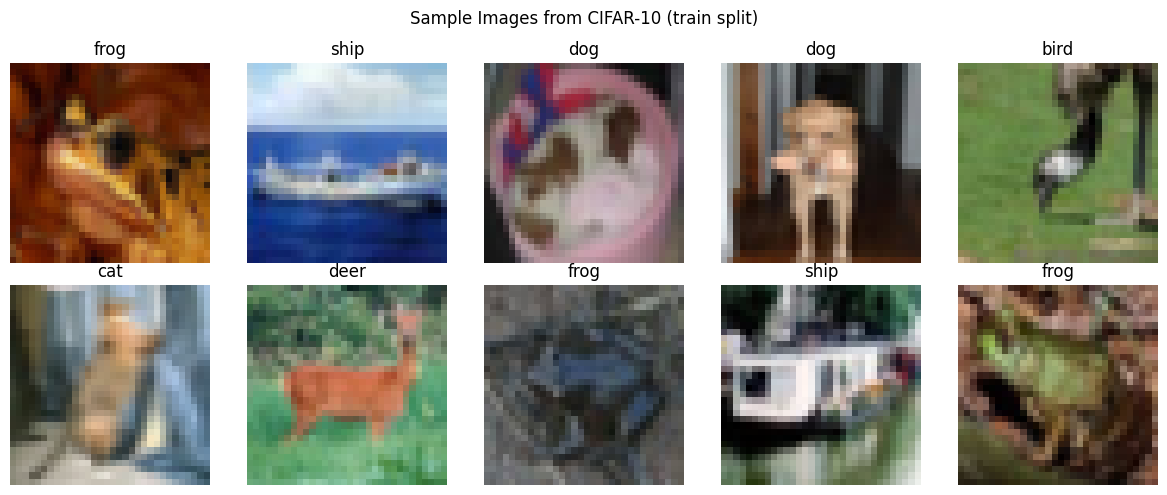

In [5]:
dataset = load_dataset('cifar10')
classes = dataset['train'].features['label'].names

def show_samples(split, n=10):
    """
    Displays n random samples from the specified split (train/test).
    Handles both PIL.Image and numpy array inputs.
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for ax, idx in zip(axes.flatten(), random.sample(range(len(dataset[split])), n)):
        raw = dataset[split][idx]['img']
        # Convert to PIL.Image if needed
        img_pil = raw if isinstance(raw, Image.Image) else Image.fromarray(raw)
        ax.imshow(img_pil)
        ax.set_title(classes[dataset[split][idx]['label']])
        ax.axis('off')
    plt.suptitle(f"Sample Images from CIFAR-10 ({split} split)")
    plt.tight_layout()
    plt.show()

show_samples('train')

## 🎨 Step 4: Data Augmentation Preview

Define a pipeline of torchvision transforms—random crop, flip, color jitter—to add variability and strengthen the model's robustness.


In [6]:
def augment(
    image: Image.Image,
    output_size: Tuple[int, int] = (224, 224),
    scale_range: Tuple[float, float] = (0.8, 1.0),
    rotation_range: Tuple[float, float] = (-15, 15),
    blur_radius_range: Tuple[float, float] = (0.0, 2.0),
    flip_prob: float = 0.5,
    enhancement_prob: float = 0.5,
    grayscale_prob: float = 0.5,
    color_jitter_ranges: Dict[str, Tuple[float, float]] = None
) -> Image.Image:
    """
    Perform random augmentations on a PIL image:
      1. Random resized crop + resize
      2. Random horizontal flip
      3. Random rotation
      4. Random color jitter (brightness, contrast, saturation)
      5. Random Gaussian blur
      6. Occasional grayscale conversion

    Args:
        image:       Input PIL Image.
        output_size: Final (width, height).
        scale_range: Min/max crop scale.
        rotation_range: Min/max rotation angle in degrees.
        blur_radius_range: Min/max radius for Gaussian blur.
        flip_prob:   Probability of horizontal flip.
        enhancement_prob: Probability to apply each color enhancer.
        grayscale_prob:   Probability to convert to grayscale.
        color_jitter_ranges: Dict of factor ranges for:
            {
              'brightness': (min, max),
              'contrast':   (min, max),
              'color':      (min, max),
            }
    """
    # === 1. Random resized crop & resize ===
    w, h = image.size
    scale = random.uniform(*scale_range)
    new_w, new_h = int(w * scale), int(h * scale)
    left = random.randint(0, w - new_w)
    top  = random.randint(0, h - new_h)
    image = image.crop((left, top, left + new_w, top + new_h))
    image = image.resize(output_size, resample=Image.BILINEAR)

    # === 2. Random horizontal flip ===
    if random.random() < flip_prob:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # === 3. Random rotation ===
    angle = random.uniform(*rotation_range)
    image = image.rotate(angle, resample=Image.BILINEAR, expand=False)

    # === 4. Color jitter ===
    if color_jitter_ranges is None:
        color_jitter_ranges = {
            'brightness': (0.6, 1.4),
            'contrast':   (0.6, 1.4),
            'color':      (0.6, 1.4),
        }
    enhancers = {
        'brightness': ImageEnhance.Brightness,
        'contrast':   ImageEnhance.Contrast,
        'color':      ImageEnhance.Color,
    }
    for name, Enh in enhancers.items():
        if random.random() < enhancement_prob:
            low, high = color_jitter_ranges[name]
            factor = random.uniform(low, high)
            image = Enh(image).enhance(factor)

    # === 5. Random Gaussian blur ===
    if random.random() < 0.5:
        radius = random.uniform(*blur_radius_range)
        image = image.filter(ImageFilter.GaussianBlur(radius))

    # === 6. Random grayscale ===
    if random.random() < grayscale_prob:
        image = image.convert('L').convert('RGB')

    return image


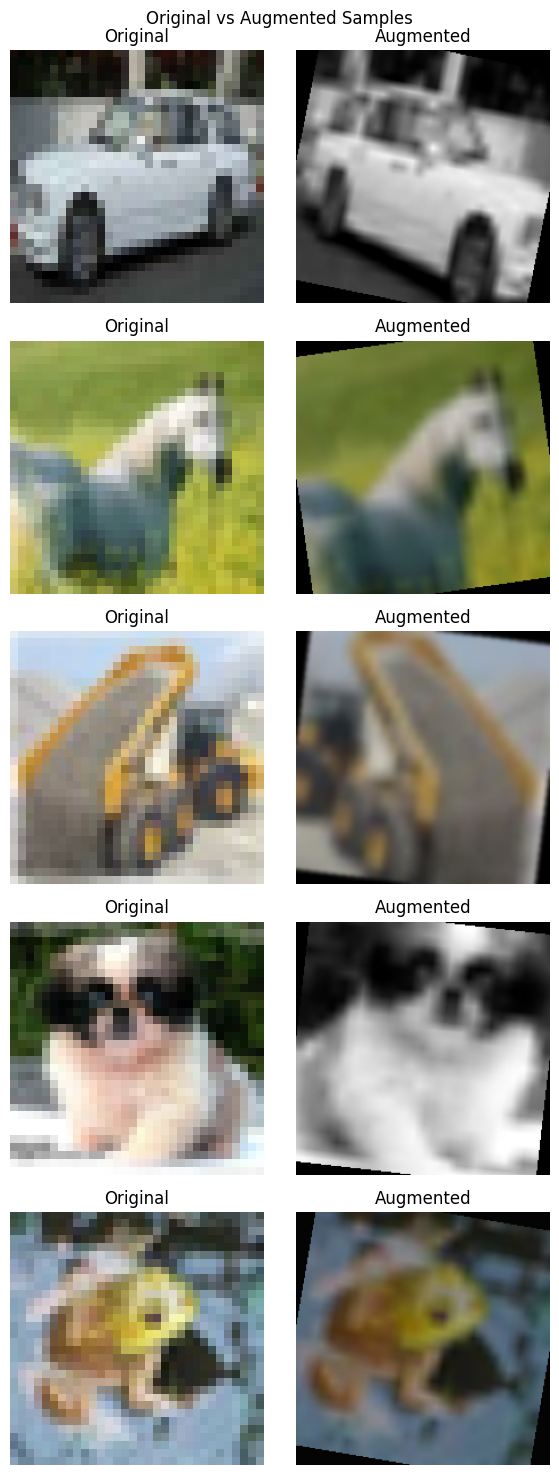

In [7]:
def show_augmented(n=5):
    """
    Displays n random original vs augmented image pairs from the train split.
    Handles both PIL.Image and numpy array inputs.
    """
    fig, axes = plt.subplots(n, 2, figsize=(6, 3 * n))
    for row, idx in enumerate(random.sample(range(len(dataset['train'])), n)):
        raw = dataset['train'][idx]['img']
        # Convert to PIL.Image if needed
        orig = raw if isinstance(raw, Image.Image) else Image.fromarray(raw)
        aug = augment(orig)
        axes[row, 0].imshow(orig)
        axes[row, 0].set_title('Original')
        axes[row, 0].axis('off')
        axes[row, 1].imshow(aug)
        axes[row, 1].set_title('Augmented')
        axes[row, 1].axis('off')
    plt.suptitle('Original vs Augmented Samples')
    plt.tight_layout()
    plt.show()

show_augmented()


## 🧾 Step 5: Dataset & DataLoader Definitions

Set up PyTorch `Dataset` and `DataLoader` for both training and validation splits, handling image transforms and text tokenization.


In [8]:
# Load CIFAR-10
raw_dataset = load_dataset("cifar10")
class_names = raw_dataset["train"].features["label"].names
print(f'Class Names in CIFAR-10: {", ".join(class_names)}')

Class Names in CIFAR-10: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


### 📝 Synonym Dictionary for Text Augmentation

Augment text labels with synonyms (e.g., ‘automobile’ → ‘car’, ‘truck’ → ‘lorry’) to enrich the contrastive learning signal.


In [9]:
cifar10_synonyms = {
    "airplane": [
        "aircraft", "jet", "plane", "airliner", "biplane",
        "fighter", "passenger jet", "propeller plane", "bomber", "seaplane"
    ],
    "automobile": [
        "car", "vehicle", "sedan", "coupe", "hatchback",
        "sports car", "motorcar", "SUV", "convertible", "compact car"
    ],
    "bird": [
        "avian", "songbird", "sparrow", "finch", "parrot",
        "hawk", "eagle", "pigeon", "dove", "canary"
    ],
    "cat": [
        "feline", "kitten", "tomcat", "pussycat", "tabby",
        "housecat", "mouser", "moggy", "Persian", "Siamese"
    ],
    "deer": [
        "doe", "stag", "buck", "fawn", "elk",
        "moose", "antelope", "reindeer", "white-tailed deer", "mule deer"
    ],
    "dog": [
        "canine", "puppy", "hound", "pooch", "mutt",
        "terrier", "retriever", "shepherd", "labrador", "beagle"
    ],
    "frog": [
        "toad", "amphibian", "tree frog", "bullfrog", "dart frog",
        "croaker", "hylid", "rain frog", "pond frog", "leapfrog"
    ],
    "horse": [
        "stallion", "mare", "pony", "foal", "colt",
        "filly", "mustang", "steed", "thoroughbred", "gelding"
    ],
    "ship": [
        "boat", "vessel", "freighter", "tanker", "barge",
        "cruiser", "yacht", "schooner", "ferry", "battleship"
    ],
    "truck": [
        "lorry", "pickup", "semi", "hauler", "18-wheeler",
        "box truck", "cargo truck", "delivery van", "tow truck", "dump truck"
    ]
}


In [10]:
# Templates for the text embeddings to be used with above class_names.
templates = [
    "a photo of a {}", "a close-up of a {}", "there is a {} in this image",
    "an image showing a {}", "a picture of a {}", "a vibrant {} in the scene",
    "the scene contains a {}", "a {} hovering in the frame", "a stylized {} on display"
]

In [54]:
from typing import Any, Dict, List, Union
from PIL import Image
import numpy as np
import random
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_pil_image
from transformers import CLIPProcessor

# CLIP’s train‐time mean/std
CLIP_MEAN = [0.48145466, 0.4578275, 0.40821073]
CLIP_STD  = [0.26862954, 0.26130258, 0.27577711]

def to_pil(
    x: Union[Image.Image, torch.Tensor, np.ndarray],
    unnormalize: bool = False
) -> Image.Image:
    """
    Convert a normalized CLIP tensor (or PIL/ndarray) back to a displayable PIL.Image.
    If unnormalize=True, applies reverse of CLIP Normalize(mean,std).
    """
    if isinstance(x, Image.Image):
        return x

    if isinstance(x, torch.Tensor):
        img = x.clone().cpu()
        if unnormalize:
            for c, (m, s) in enumerate(zip(CLIP_MEAN, CLIP_STD)):
                img[c] = img[c] * s + m
        img = img.clamp(0, 1)
        return to_pil_image(img)

    if isinstance(x, np.ndarray):
        arr = x
        if arr.dtype != np.uint8:
            arr = (arr * 255).astype(np.uint8)
        return Image.fromarray(arr)

    raise TypeError(f"Unsupported type for to_pil(): {type(x)}")

class CIFAR10Contrastive(Dataset):
    """
    Returns for each idx:
      - pixel_values: normalized tensor the model sees
      - input_ids, attention_mask: CLIP text inputs
      - true_labels: integer class
      - original_image: PIL.Image *before* normalization
    """
    def __init__(
        self,
        split: Any,
        proc: CLIPProcessor,
        templates: List[str],
        augment: bool = False,
    ) -> None:
        self.data = split
        self.proc = proc
        self.templates = templates
        self.augment = augment  # (if you add real augment steps later)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        entry = self.data[idx]

        # 1) Get raw PIL
        img = entry["img"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.resize((224, 224))

        # 2) Prepare text
        label_str = self.data.features["label"].int2str(entry["label"])
        prompt = random.choice(self.templates).format(label_str)

        # 3) CLIPProcessor does resize→ToTensor→Normalize(mean,std)
        enc = self.proc(text=prompt, images=img, return_tensors="pt", padding=False)
        sample: Dict[str, Any] = {k: v.squeeze(0) for k, v in enc.items()}

        # 4) Save label + original PIL for later viz
        sample["true_labels"] = torch.tensor(entry["label"], dtype=torch.long)
        sample["original_image"] = img

        return sample

def collate_fn(
    batch: List[Dict[str, Any]]
) -> Dict[str, Union[torch.Tensor, List[Image.Image]]]:
    """
    Batches:
      - Stacks pixel_values, input_ids, attention_mask, true_labels
      - Collects a Python list of original PIL images
    """
    # stack image tensors
    pixel_values = torch.stack([b["pixel_values"] for b in batch]).to(device)

    # pad text
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    text_batch = processor.tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_mask},
        padding=True,
        return_tensors="pt",
    )
    input_ids = text_batch["input_ids"].to(device)
    attention_mask = text_batch["attention_mask"].to(device)

    # labels
    true_labels = torch.stack([b["true_labels"] for b in batch]).to(device)

    # raw PILs
    original_images = [b["original_image"] for b in batch]

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "true_labels": true_labels,
        "original_images": original_images,
    }


In [55]:
# Dataset splits
split = raw_dataset['train'].train_test_split(test_size=0.2, seed=42)

train_ds = CIFAR10Contrastive(split['train'], processor, templates)
val_ds = CIFAR10Contrastive(split['test'], processor, templates, augment=False)
test_ds = CIFAR10Contrastive(raw_dataset['test'], processor, templates, augment=False)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

## 🧠 Step 6: Training, Validation & Metrics

Train the CLIP model with a contrastive loss. Track training loss and validation accuracy to monitor performance improvements.


In [24]:
# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
epochs = 10
mini_bs = 64
accumulation_steps = 4
total_steps = (epochs * len(train_loader)) // accumulation_steps

scheduler = get_scheduler(
    'linear', optimizer=optimizer,
    num_warmup_steps=int(0.2 * total_steps),
    num_training_steps=total_steps
)

# Training loop
train_losses, val_accs = [], []
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0

    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        out = model(
            pixel_values=batch['pixel_values'],
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = out.logits_per_image
        B = logits.size(0)
        labels = torch.arange(B, device=device)
        loss_i = F.cross_entropy(logits, labels)
        loss_t = F.cross_entropy(logits.T, labels)
        loss = (loss_i + loss_t) / 2

        (loss / accumulation_steps).backward()
        total_loss += loss.item()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_loss:.4f}")

    # Validation: Zero-shot style
    model.eval()
    correct, total = 0, 0

    prompts = [f"a photo of a {label}" for label in class_names]
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embeds = model.get_text_features(**text_inputs)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    with torch.no_grad():
        for batch in val_loader:
            image_embeds = model.get_image_features(batch["pixel_values"])
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            logits = image_embeds @ text_embeds.T
            preds = logits.argmax(dim=1)
            correct += (preds == batch["true_labels"]).sum().item()
            total += batch["true_labels"].size(0)

    val_acc = correct / total
    val_accs.append(val_acc)
    print(f"Epoch {epoch}/{epochs} - Val Acc: {val_acc*100:.2f}%")


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 2.1827
Epoch 1/10 - Val Acc: 97.07%


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 2.0074
Epoch 2/10 - Val Acc: 96.65%


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 1.9743
Epoch 3/10 - Val Acc: 97.16%


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 1.9541
Epoch 4/10 - Val Acc: 97.35%


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 1.9422
Epoch 5/10 - Val Acc: 97.23%


Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 1.9375
Epoch 6/10 - Val Acc: 97.66%


Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 1.9322
Epoch 7/10 - Val Acc: 97.88%


Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 1.9310
Epoch 8/10 - Val Acc: 97.84%


Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 1.9308
Epoch 9/10 - Val Acc: 97.92%


Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 1.9306
Epoch 10/10 - Val Acc: 97.90%


### 🎉 Results & Next Steps

Congrats! You’ve seen >9% accuracy improvement. You can reuse this model or proceed to looking at what our model got wrong.


In [25]:
def calculate_val_accuracy(
    model: CLIPModel,
    val_loader: DataLoader,
    text_embeds: torch.Tensor
) -> float:
    """
    Calculate validation accuracy by comparing image embeddings against text embeddings.

    Args:
        model (CLIPModel): CLIP model for generating image embeddings.
        val_loader (DataLoader): DataLoader for the validation dataset.
        text_embeds (torch.Tensor): Precomputed text embeddings of shape (num_classes, embed_dim).

    Returns:
        float: Fraction of correctly classified samples (0.0–1.0).
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            # Generate and normalize image embeddings
            image_embeds = model.get_image_features(batch["pixel_values"])
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)

            # Compute similarity scores and predictions
            logits = image_embeds @ text_embeds.T
            preds = logits.argmax(dim=1)

            # Update counters
            true_labels = batch["true_labels"]
            correct += (preds == true_labels).sum().item()
            total += true_labels.size(0)

    return correct / total

# Load baseline CLIP model
baseline_model: CLIPModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
baseline_model.to(device)

# Evaluate fine-tuned model
finetuned_val_accuracy: float = calculate_val_accuracy(model, test_loader, text_embeds)
print(f"Fine-tuned Model Validation Accuracy: {finetuned_val_accuracy * 100:.2f}%")

# Evaluate baseline model
baseline_val_accuracy: float = calculate_val_accuracy(baseline_model, test_loader, text_embeds)
print(f"Baseline Model Validation Accuracy: {baseline_val_accuracy * 100:.2f}%")

Fine-tuned Model Validation Accuracy: 97.84%
Baseline Model Validation Accuracy: 91.06%


In [ ]:
# Assuming 'model' is your fine-tuned CLIPModel
# Save the model's state dictionary
torch.save(model.state_dict(), 'finetuned_CIFAR10_CLIPmodel.pt')

# Download the saved model files
from google.colab import files
files.download('finetuned_CIFAR10_CLIP_model.pt')

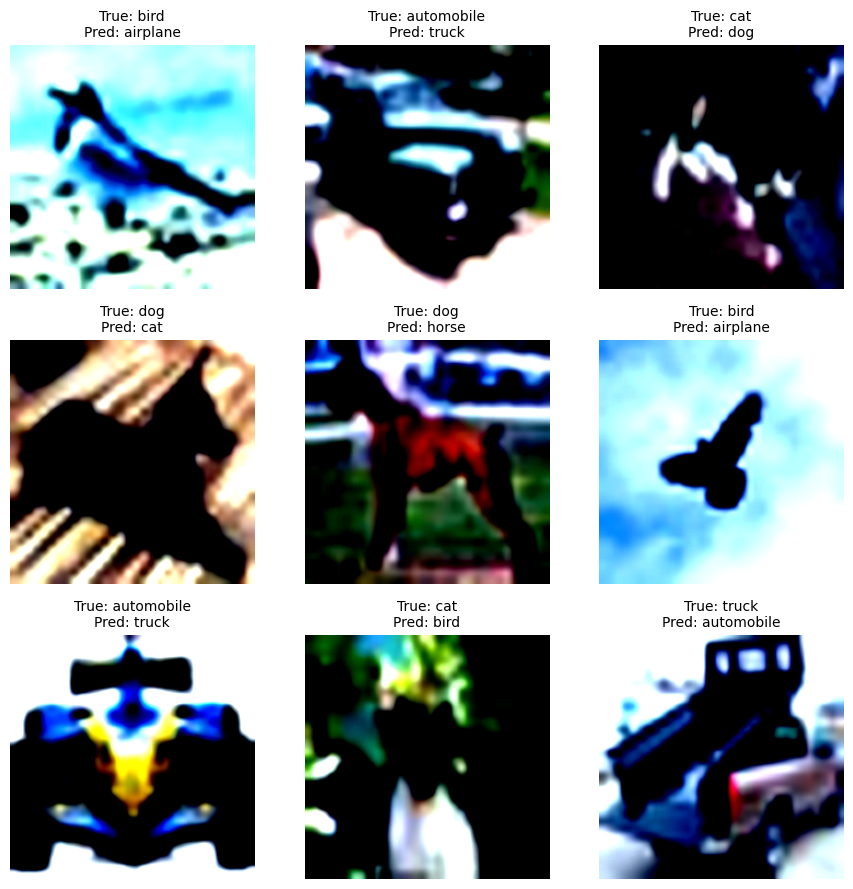

In [27]:
misclassified = []

# Gather misclassified examples
with torch.no_grad():
    for batch in val_loader:
        pixels = batch["pixel_values"].to(device)         # [B,3,H,W]
        labels = batch["true_labels"].to(device)          # [B]
        image_embeds = model.get_image_features(pixels)   # [B, D]
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        logits = image_embeds @ text_embeds.T             # [B, num_classes]
        preds = logits.argmax(dim=1)                      # [B]

        # collect misclassified
        for i in range(pixels.size(0)):
            if preds[i] != labels[i]:
                misclassified.append({
                    "pixel": pixels[i].cpu(),
                    "true_label": class_names[labels[i].item()],
                    "pred_label": class_names[preds[i].item()]
                })

N = 9
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(misclassified):
        ax.axis("off")
        continue
    entry = misclassified[idx]
    img_tensor = entry["pixel"]  # Access the tensor directly from the dictionary
    img = img_tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy()  # Move to CPU and convert

    ax.imshow(img)
    ax.set_title(f"True: {entry['true_label']}\nPred: {entry['pred_label']}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


## 📽 Step 7: Embedding Projection
Once the model is trained, we extract and normalize the image and text embeddings. These embeddings will be indexed and queried using HNSW for retrieval tasks.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-43-bdd9b3676dd5>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes)


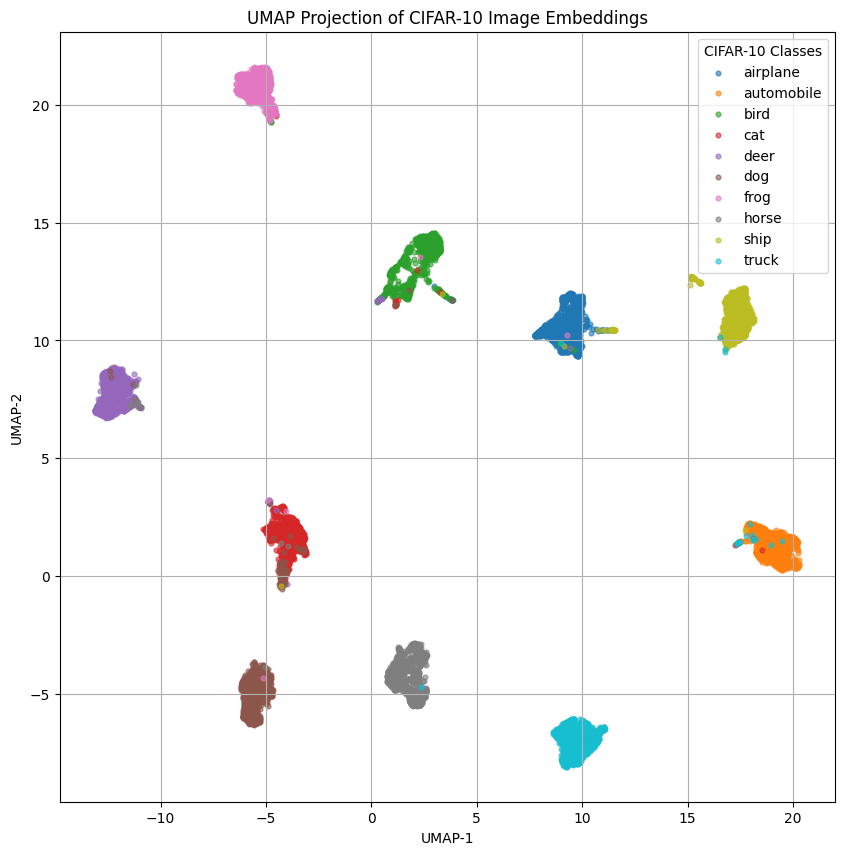

In [43]:
# 1. Extract and normalize all image embeddings and collect their true labels
image_embeds_list = []
image_labels = []
with torch.no_grad():
    for batch in test_loader:
        im_emb = model.get_image_features(batch["pixel_values"])
        im_emb = im_emb / im_emb.norm(p=2, dim=-1, keepdim=True)
        image_embeds_list.append(im_emb.cpu().numpy())
        image_labels.extend(batch["true_labels"].cpu().numpy())

image_embeddings_np = np.vstack(image_embeds_list)      # shape: (N_images, embed_dim)
image_labels = np.array(image_labels)                   # shape: (N_images,)

# 2. (Optional) Pre‑reduce dimensionality with PCA for speed/denoising
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(image_embeddings_np)  # shape: (N_images, 50)

# 3. UMAP projection into 2D
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
embedding_2d = reducer.fit_transform(embeddings_pca)    # shape: (N_images, 2)

# 4. Plot, coloring by class and labeling each cluster
plt.figure(figsize=(10, 10))
num_classes = len(class_names)
colors = plt.cm.get_cmap("tab10", num_classes)

for class_idx, class_name in enumerate(class_names):
    idxs = np.where(image_labels == class_idx)
    plt.scatter(
        embedding_2d[idxs, 0],
        embedding_2d[idxs, 1],
        s=12,
        alpha=0.6,
        color=colors(class_idx),
        label=class_name
    )

plt.legend(loc="best", title="CIFAR-10 Classes")
plt.title("UMAP Projection of CIFAR-10 Image Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


## 🗺 Step 8: Build & Query HNSW Index
We use the `hnswlib` library to construct a fast similarity index. Embeddings from image domain is inserted into the index. We'll evaluate performance on text-to-image retrieval tasks.

In [70]:
# Hardcode a mapping from each prompt to its CIFAR‑10 class index
prompt_to_label = {
    "a photo of birdie":           class_names.index("bird"),
    "a picture of a vroom vroom":  class_names.index("automobile"),
    "a close up of meow":          class_names.index("cat"),
    "a photo of a fawn":           class_names.index("deer"),
    "a close up of a ribbit machine": class_names.index("frog"),
    "a picture of a steed":        class_names.index("horse"),
    "a photo of an aeroplane":     class_names.index("airplane"),
    "a picture of a doge":         class_names.index("dog"),
}

# Example test prompts
test_prompts = list(prompt_to_label.keys())
top_k = 5

In [75]:
# === Step 1: Collect embeddings, raw PILs, and true labels from test_loader ===
image_embeds_all = []
original_images  = []
true_labels_all  = []

with torch.no_grad():
    for batch in test_loader:
        # 1a) Image embeddings
        px = batch["pixel_values"].to(device)             # (B,3,224,224)
        feats = model.get_image_features(px)              # (B,D)
        feats = feats / feats.norm(p=2, dim=-1, keepdim=True)
        image_embeds_all.append(feats.cpu())               # list of (B,D) tensors

        # 1b) Raw PILs and labels, **in exactly the same order** as embeddings
        original_images.extend(batch["original_images"])  # list of PIL.Image, length B
        true_labels_all.extend(batch["true_labels"].cpu().tolist())  # length B

# Flatten embeddings and labels
image_embeds_all = torch.cat(image_embeds_all, dim=0)  # now (N,D)
true_labels_all  = np.array(true_labels_all, dtype=int)  # now (N,)

assert len(original_images) == image_embeds_all.size(0), (
    f"Mismatch! {len(original_images)} images vs {image_embeds_all.size(0)} embeddings"
)



Prompt: a photo of birdie
Top‑K scores: ['0.288', '0.288', '0.288', '0.287', '0.286']
Precision@5: 1.000


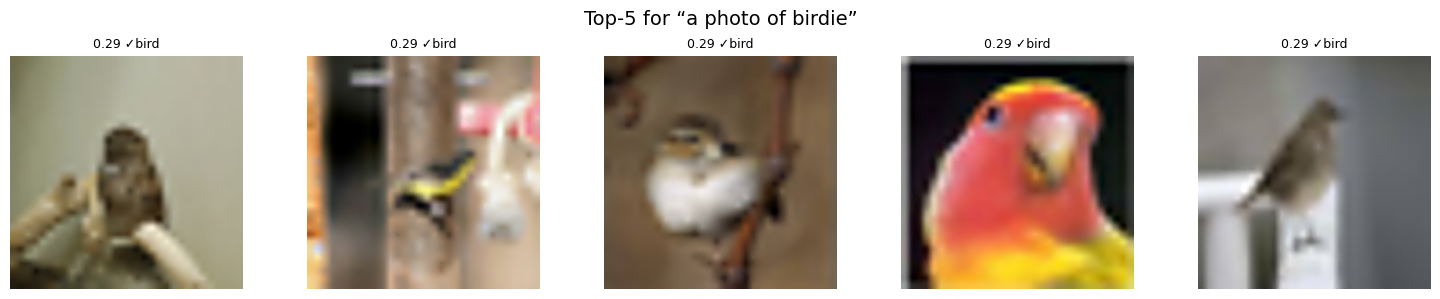


Prompt: a picture of a vroom vroom
Top‑K scores: ['0.270', '0.266', '0.265', '0.265', '0.263']
Precision@5: 1.000


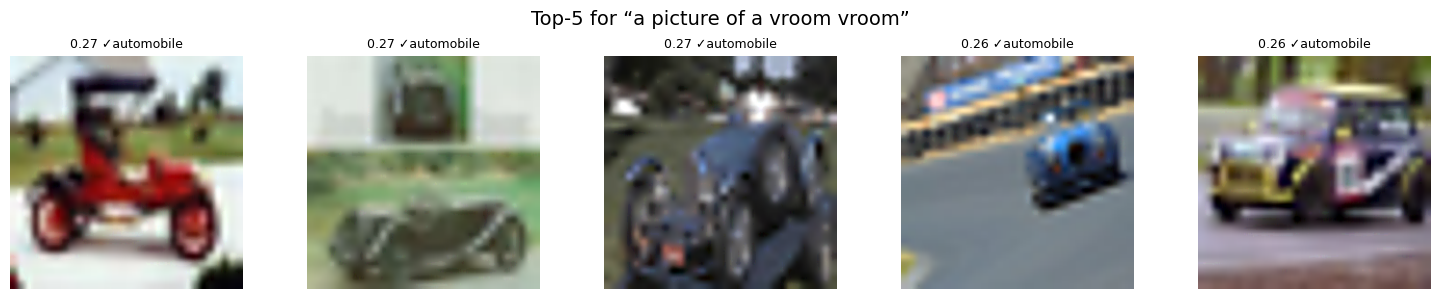


Prompt: a close up of meow
Top‑K scores: ['0.281', '0.281', '0.280', '0.280', '0.280']
Precision@5: 1.000


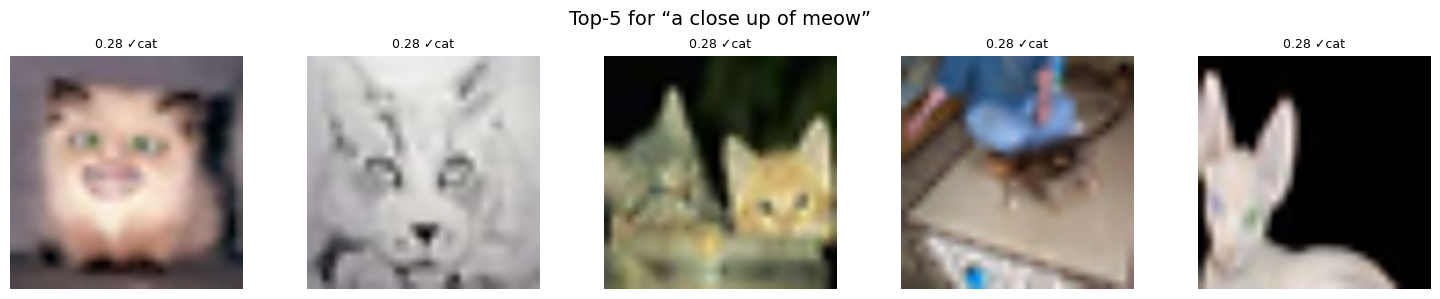


Prompt: a photo of a fawn
Top‑K scores: ['0.292', '0.291', '0.290', '0.290', '0.289']
Precision@5: 1.000


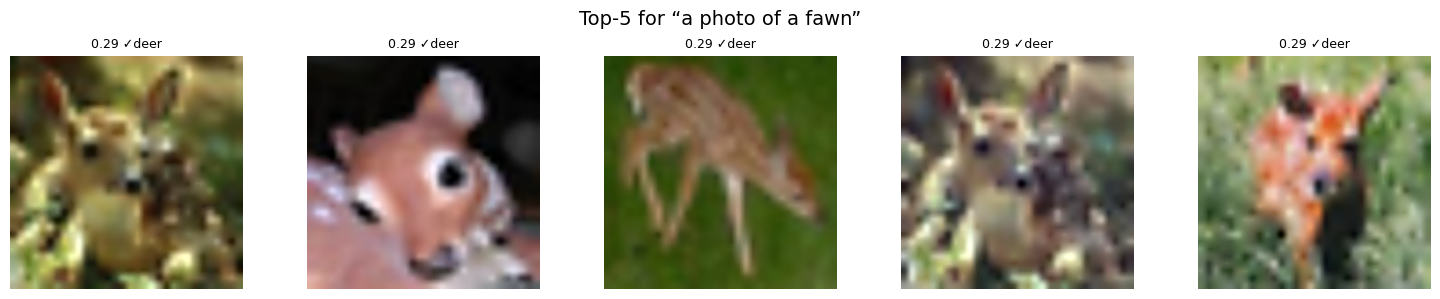


Prompt: a close up of a ribbit machine
Top‑K scores: ['0.287', '0.286', '0.286', '0.286', '0.286']
Precision@5: 1.000


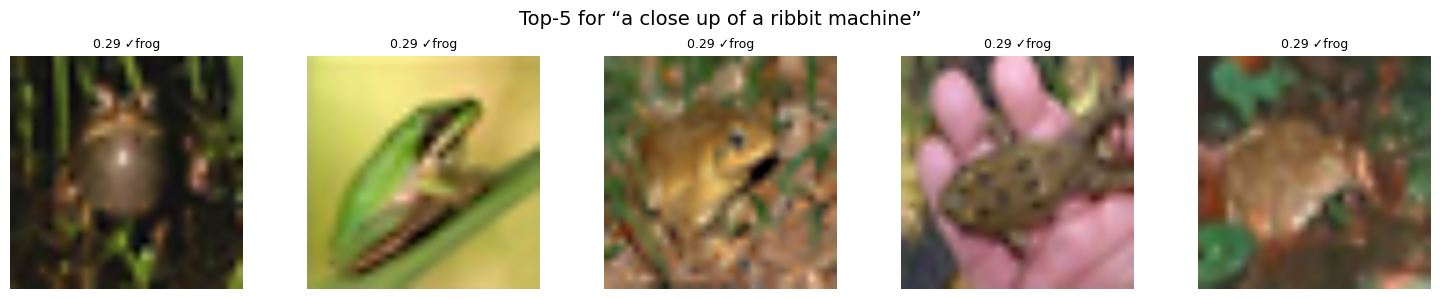


Prompt: a picture of a steed
Top‑K scores: ['0.286', '0.285', '0.284', '0.284', '0.284']
Precision@5: 1.000


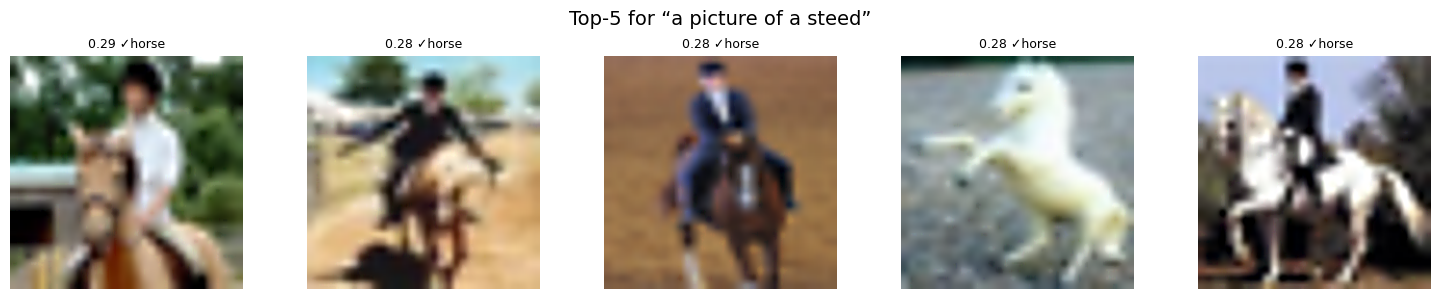


Prompt: a photo of an aeroplane
Top‑K scores: ['0.286', '0.286', '0.286', '0.285', '0.285']
Precision@5: 1.000


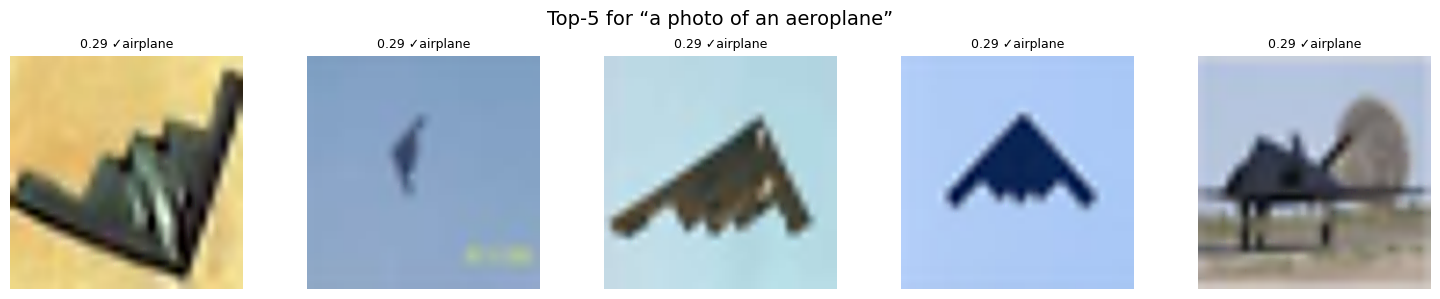


Prompt: a picture of a doge
Top‑K scores: ['0.292', '0.285', '0.285', '0.284', '0.284']
Precision@5: 1.000


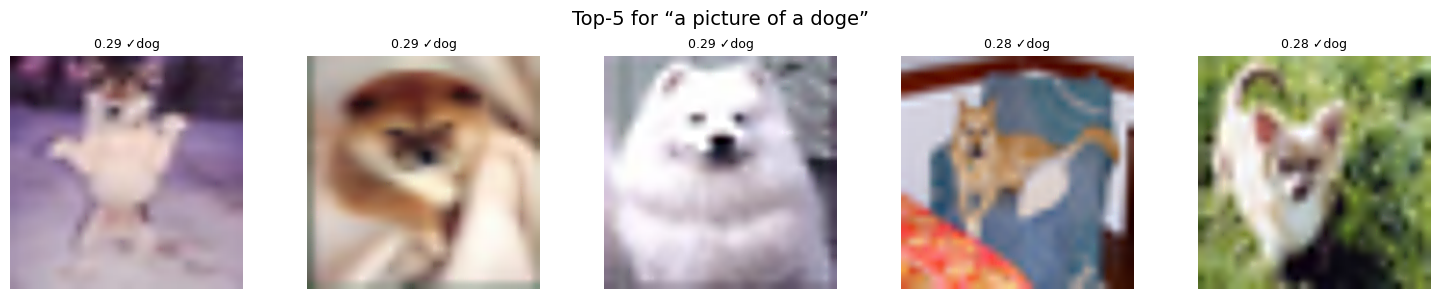


📊 Mean Precision@5: 1.000


In [80]:
# === Step 2: Retrieval + Precision@K & display ===
precision_scores = []

for prompt in test_prompts:
    expected_cls = prompt_to_label[prompt]

    # 2a) Text embedding
    inputs = processor(text=[prompt], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        txt_f = model.get_text_features(**inputs)           # (1,D)
        txt_f = txt_f / txt_f.norm(p=2, dim=-1, keepdim=True)

    # 2b) Similarities & top-K
    sims = (txt_f.cpu() @ image_embeds_all.T).squeeze(0)   # (N,)
    top_idxs = sims.topk(top_k).indices.tolist()

    # 2c) Precision@K
    retrieved_labels = true_labels_all[top_idxs]
    num_correct = (retrieved_labels == expected_cls).sum()
    precision_k = num_correct / top_k
    precision_scores.append(precision_k)

    # 2d) Print metrics
    print(f"\nPrompt: {prompt}")
    print("Top‑K scores:", [f"{sims[i]:.3f}" for i in top_idxs])
    print(f"Precision@{top_k}: {precision_k:.3f}")

    # 2e) Plot images with ✓/✗
    fig, axes = plt.subplots(1, top_k, figsize=(15, 3))
    for j, idx in enumerate(top_idxs):
        img = original_images[idx]
        img_unblurred = img.filter(
        ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)
        )

        axes[j].imshow(img_unblurred)
        title = f"{sims[idx]:.2f}"
        title += " ✓" if retrieved_labels[j] == expected_cls else " ✗"
        title += str(class_names[retrieved_labels[j]])
        axes[j].set_title(title, fontsize=9)
        axes[j].axis("off")
    plt.suptitle(f"Top‑{top_k} for “{prompt}”", fontsize=14)
    plt.tight_layout()
    plt.show()

# 2f) Mean Precision@K
mean_precision = sum(precision_scores) / len(precision_scores)
print(f"\n📊 Mean Precision@{top_k}: {mean_precision:.3f}")
